In [1]:
# system
import warnings
import os

# operation
import pandas as pd
import numpy as np
import pickle

# visulization
import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# modeling
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format = 'retina'

In [2]:
df1 = pd.read_excel('../dataset/bank_data.xlsx')
df2 = pd.read_excel('../dataset/cibil_data.xlsx')

In [3]:
# extensive data of the customers 
df = pd.merge(df1, df2, 'inner', on='PROSPECTID')

In [4]:
# saving dataframe with pickle, faster upload
df.to_pickle('../artifacts/full_data.pkl')
df.to_csv('../artifacts/full_data.csv', index=False)

In [5]:
df = pd.read_pickle('../artifacts/full_data.pkl')
df.shape

df_full = df.copy()

The -99999 are used for null value, and should be rectified

In [6]:
# impute -99999 with null
df.replace(-99999, np.nan, inplace=True)

In [7]:
# null_col: column with null values
null_col = df.isna().sum()[lambda x: x > 0].index
df[null_col].isna().sum().sort_values()

Age_Oldest_TL                      40
Age_Newest_TL                      40
pct_currentBal_all_TL              72
time_since_recent_payment        4291
enq_L3m                          6321
enq_L6m                          6321
enq_L12m                         6321
time_since_recent_enq            6321
PL_enq_L12m                      6321
PL_enq_L6m                       6321
PL_enq                           6321
CC_enq_L12m                      6321
CC_enq_L6m                       6321
CC_enq                           6321
tot_enq                          6321
max_deliq_12mts                 10832
max_deliq_6mts                  12890
max_unsec_exposure_inPct        23178
max_delinquency_level           35949
time_since_recent_deliquency    35949
time_since_first_deliquency     35949
PL_utilization                  44435
CC_utilization                  47636
dtype: int64

* PL_utilization and CC_utilization are only features associated with utilization of TL, and cannot be imputed with confidence.This features needs to be dropped.
* time_since_first_deliquency, time_since_recent_deliquency, and max_delinquency_level are related to customer default/deliquency. There are many more features related to deliquency, require further analysis before making any decision.
* max_unsec_exposure_inPct have 2 related features (Secured_TL, Unsecured_TL) which does not show any direction correlation with `maximum %(exposure to unsecured TL)`. This column cannot be immputed and should be dropped.
* max_deliq_6mts, and max_deliq_12mts are similar to point 2, about default/deliquency. 
* Alot of features have 6321 null values (-99999). 
* `time_since_recent_payment` also need further analysis, however there is no feature to interpret these missing values.

In [8]:
df.columns

Index(['PROSPECTID', 'Total_TL', 'Tot_Closed_TL', 'Tot_Active_TL',
       'Total_TL_opened_L6M', 'Tot_TL_closed_L6M', 'pct_tl_open_L6M',
       'pct_tl_closed_L6M', 'pct_active_tl', 'pct_closed_tl',
       'Total_TL_opened_L12M', 'Tot_TL_closed_L12M', 'pct_tl_open_L12M',
       'pct_tl_closed_L12M', 'Tot_Missed_Pmnt', 'Auto_TL', 'CC_TL',
       'Consumer_TL', 'Gold_TL', 'Home_TL', 'PL_TL', 'Secured_TL',
       'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL', 'Age_Newest_TL',
       'time_since_recent_payment', 'time_since_first_deliquency',
       'time_since_recent_deliquency', 'num_times_delinquent',
       'max_delinquency_level', 'max_recent_level_of_deliq', 'num_deliq_6mts',
       'num_deliq_12mts', 'num_deliq_6_12mts', 'max_deliq_6mts',
       'max_deliq_12mts', 'num_times_30p_dpd', 'num_times_60p_dpd', 'num_std',
       'num_std_6mts', 'num_std_12mts', 'num_sub', 'num_sub_6mts',
       'num_sub_12mts', 'num_dbt', 'num_dbt_6mts', 'num_dbt_12mts', 'num_lss',
       'num_lss_6mts', 'n

In [9]:
df[['Age_Newest_TL', 'Age_Oldest_TL', 'pct_currentBal_all_TL']].isna().value_counts()

Age_Newest_TL  Age_Oldest_TL  pct_currentBal_all_TL
False          False          False                    51226
                              True                        70
True           True           False                       38
                              True                         2
Name: count, dtype: int64

# Handling Null Values

### Analysis for trade line features

In [10]:
df[df[['Age_Newest_TL', 'Age_Oldest_TL', 'pct_currentBal_all_TL']].isna().sum(axis=1) > 0][['Total_TL']].value_counts()

Total_TL
1           77
2           16
3            5
4            5
6            3
5            2
7            1
18           1
Name: count, dtype: int64

In [11]:
### Dropping customer entries with null age and balance 
df.dropna(subset=['Age_Oldest_TL', 'Age_Newest_TL', 'pct_currentBal_all_TL'], inplace=True)

# dropping utilization features
df.drop(['PL_utilization', 'CC_utilization', 'max_unsec_exposure_inPct'], axis=1, inplace=True)

df.shape

(51226, 84)

### Analysis for deliquency features

In [12]:
# delinquency features with more than 50% null values

null_deq_col = ['time_since_first_deliquency', 'time_since_recent_deliquency', 'max_delinquency_level', 'max_deliq_12mts', 'max_deliq_6mts']
rest_deq_col = ['num_times_delinquent', 'max_recent_level_of_deliq', 'num_deliq_6mts', 'num_deliq_12mts', 'num_deliq_6_12mts', 'recent_level_of_deliq']

df[null_deq_col].isna().value_counts()

time_since_first_deliquency  time_since_recent_deliquency  max_delinquency_level  max_deliq_12mts  max_deliq_6mts
True                         True                          True                   False            False             25659
False                        False                         False                  False            False             12769
True                         True                          True                   True             True               9064
False                        False                         False                  True             True               1677
True                         True                          True                   False            True               1122
False                        False                         False                  False            True                935
Name: count, dtype: int64

In [13]:
# check for any deq in customer history
null_deli_series = df.num_times_delinquent[df[null_deq_col].isna().sum(axis=1) == 3]
null_deli_series.value_counts()

num_times_delinquent
0    25659
Name: count, dtype: int64

In [14]:
# cross verify / double check

df.max_delinquency_level[df['num_times_delinquent'] == 0].isna().value_counts()

max_delinquency_level
True    35845
Name: count, dtype: int64

If a customer has no default/deliquency than their 'time_since_first_deliquency', 'time_since_recent_deliquency', 'max_delinquency_level' will be 0. Similar can be said for other deliquency related feature like max_deliq_12mts.

In [15]:
# fill null deq with 0
df[null_deq_col] = df[null_deq_col].fillna(0)

In [16]:
df.loc[df['num_times_delinquent'] == 0, null_deq_col] = df.loc[df['num_times_delinquent'] == 0, null_deq_col].fillna(0)

In [17]:
df[null_deq_col].isna().sum()

time_since_first_deliquency     0
time_since_recent_deliquency    0
max_delinquency_level           0
max_deliq_12mts                 0
max_deliq_6mts                  0
dtype: int64

In [18]:
other_null_deq = df[['max_deliq_12mts', 'max_deliq_6mts']].isna()
other_null_deq.value_counts()

max_deliq_12mts  max_deliq_6mts
False            False             51226
Name: count, dtype: int64

In [19]:
# impute 0 for other null deq if num of deq is 0
remain_null_deq_col = ['max_deliq_6mts', 'max_deliq_12mts']

# remaining null deq
df[remain_null_deq_col].isna().value_counts()

max_deliq_6mts  max_deliq_12mts
False           False              51226
Name: count, dtype: int64

In [20]:
reamining_null_deq_series = df[remain_null_deq_col].isna().sum(axis=1)
reamining_null_deq_series.value_counts()

0    51226
Name: count, dtype: int64

In [21]:
print(
    df.loc[reamining_null_deq_series == 1][['num_deliq_12mts',  'num_deliq_6_12mts', 'num_deliq_6mts']].value_counts(),
    "\n\n",
    df.loc[reamining_null_deq_series == 2][['num_deliq_12mts',  'num_deliq_6_12mts', 'num_deliq_6mts']].value_counts()
)

Series([], Name: count, dtype: int64) 

 Series([], Name: count, dtype: int64)


In [22]:
# when no deliquency is last 6 months is recorded
df.loc[reamining_null_deq_series == 1, 'max_deliq_6mts'] = df.loc[reamining_null_deq_series == 1, 'max_deliq_6mts'].fillna(0)

# when no deliquency is last 12 months is recorded
df.loc[reamining_null_deq_series == 2, ['max_deliq_6mts', 'max_deliq_12mts']] = df.loc[reamining_null_deq_series == 2, ['max_deliq_6mts', 'max_deliq_12mts']].fillna(0)

### Analysis of enquiry features

In [23]:
null_col = df.isna().sum(axis=0)[lambda x: x>0].index
df[null_col].isna().sum(axis=0).sort_values()

time_since_recent_payment    4248
tot_enq                      6277
CC_enq                       6277
CC_enq_L6m                   6277
CC_enq_L12m                  6277
PL_enq                       6277
PL_enq_L6m                   6277
PL_enq_L12m                  6277
time_since_recent_enq        6277
enq_L12m                     6277
enq_L6m                      6277
enq_L3m                      6277
dtype: int64

In [24]:
# null enq columns which have NAN for 6277 customers.
null_enq_col = ['tot_enq', 'CC_enq', 'CC_enq_L6m', 'enq_L3m', 'PL_enq', 'PL_enq_L6m', 'PL_enq_L12m', 'time_since_recent_enq', 'enq_L12m', 'enq_L6m', 'CC_enq_L12m']
remain_enq_col = ['pct_PL_enq_L6m_of_L12m', 'pct_CC_enq_L6m_of_L12m', 'pct_PL_enq_L6m_of_ever', 'pct_CC_enq_L6m_of_ever', 'last_prod_enq2', 'first_prod_enq2']

df[null_enq_col].isna().sum(axis=1).value_counts()

0     44949
11     6277
Name: count, dtype: int64

In [25]:
df[remain_enq_col].loc[df[null_enq_col].isna().sum(axis=1) == 11]

,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,last_prod_enq2,first_prod_enq2
3,0.0,0.0,0.0,0.0,others,others
6,0.0,0.0,0.0,0.0,others,others
9,0.0,0.0,0.0,0.0,others,others
11,0.0,0.0,0.0,0.0,others,others
17,0.0,0.0,0.0,0.0,others,others
...,...,...,...,...,...,...
51293,0.0,0.0,0.0,0.0,others,others
51306,0.0,0.0,0.0,0.0,others,others
51315,0.0,0.0,0.0,0.0,others,others
51319,0.0,0.0,0.0,0.0,others,others


6321 customer are about 12% of the dataset and have 11 missing entries (related to enq) per customer. These customer record needs to be removed since the remaining variable isn't suffient to impute null with confidence.

Dropping customer record to save enquire data is a viable and better approach as dropping features would result in no absolute enquire related feature.

In [26]:
# picked any enq feature as there's no sparsity in missing values of enq features.
df.dropna(subset=['tot_enq'], inplace=True)
df.shape

(44949, 84)

### Analysing remaining features with NULL

In [27]:
df.isna().sum(axis=0)[lambda x: x>0]

time_since_recent_payment    2885
dtype: int64

In [28]:
# The 'time_since_recent_payment' with null entries contributes around 5% of total remaining record and have no feature to infer the value. These entries can be dropped

df = df.dropna(subset=['time_since_recent_payment'])

df.isna().sum(axis=1).sum()

0

In [29]:
df.shape

(42064, 84)

# Handling Associated features

In [30]:
# testing feature correlation with target feature.
numeric = df.select_dtypes(exclude='object').columns.drop(['PROSPECTID'])
categoric = df.select_dtypes(include='object').columns.drop(['Approved_Flag'])

col_keep = []
    
# categorical vs numeric feature using anova test
for i in numeric:
    x = list(df[i]) 
    y = list(df['Approved_Flag'])  
    
    group_P1 = [value for value, group in zip(x, y) if group == 'P1']
    group_P2 = [value for value, group in zip(x, y) if group == 'P2']
    group_P3 = [value for value, group in zip(x, y) if group == 'P3']
    group_P4 = [value for value, group in zip(x, y) if group == 'P4']

    f_statistic, p_value = f_oneway(group_P1, group_P2, group_P3, group_P4)

    if p_value <= 0.05:
        col_keep.append(i)

num_corr = len(col_keep)
print(num_corr, 'numeric features show correlation with target variable (Approval_Flag)')
        
# categorical vs categorical features using chi square test
for i in categoric:
    chi2, p_value, _, _ = chi2_contingency(pd.crosstab(df[i], df['Approved_Flag']))
    
    if p_value <= 0.05:
        col_keep.append(i)
        
print(len(col_keep)-num_corr, 'categoric features show correlation with target variable (Approval_Flag)')

74 numeric features show correlation with target variable (Approval_Flag)
5 categoric features show correlation with target variable (Approval_Flag)


In [31]:
# treating multi-collinearity (associated dependent features) using vif
numeric_col = df.select_dtypes(exclude=object).columns.drop(['PROSPECTID'])
keep_col = numeric_col.copy()
drop_col = list()
threshold = 10  # > 5 or 10 is considered highly associted

for i in range(numeric_col.size):
    array = df[keep_col].values
    index = list(keep_col).index(numeric_col[i])
    vif = variance_inflation_factor(array, index)
    
    ## print(numeric_col[i] ,'=', keep_col[index])
    # print(i, '!=', index)
    
    if vif > threshold:
        ## print('drop:', i, numeric_col[i])
        drop = numeric_col[i]
        drop_col.append(drop)
        keep_col = keep_col[keep_col != drop]
        
# recalculate vif 
array = df[keep_col].values 
vif_values = pd.DataFrame( [(keep_col[i], variance_inflation_factor(array, i)) for i in range(keep_col.size)], 
             columns=['feature', 'vif'] )

print(keep_col.size, 'features shows low-moderate assocaition with other feature')

53 features shows low-moderate assocaition with other feature


Based on the banking trade-line domain knowledge:
1. std (standard payment) = timely payment; may show low correlation with approval_flag (customer type - priority levels)
2. sub (sub-standard payment) = significant days default (mostly above 90days); 
3. dbt (doubtful payment) = prolonged nonpayment (180 days); may show high correction with approval_flag
4. tl_open/close = trade-line (loan) opened/closed; may show moderate correction with approval flag
5. deliq_level (deliquency level) = scoring system of risk with account holder, higher score means higher risk for lending; 
 may show high correlation with approval_flag
6. pl_enq (personal loan enquire) = number of enq for personal loan as per cibil report; may show moderate correlation
7. lss (loss account); may show high correction

- 9 tl_open/closed features and 8 are in high vif; Removing highest one may improve vif of others.
- 3 deliq_level features are present; can't remove all as it may show moderate-high correlation with target
- 2 std feature are present; can be removed as it may not show high correlation and have high vif.
- 2 pl_enq features and 1 is very high vif; 1 can be removed
- 3 dbt and lss features present respectively and 2 are high vif; 2 can be removed as 1 is already present

removing the last 6 high features (PL_enq, max_recent_level_of_deliq, Tot_TL_closed_L6M, num_lss_12mts, Tot_TL_closed_L12M, num_dbt_12mts) and recheck vif

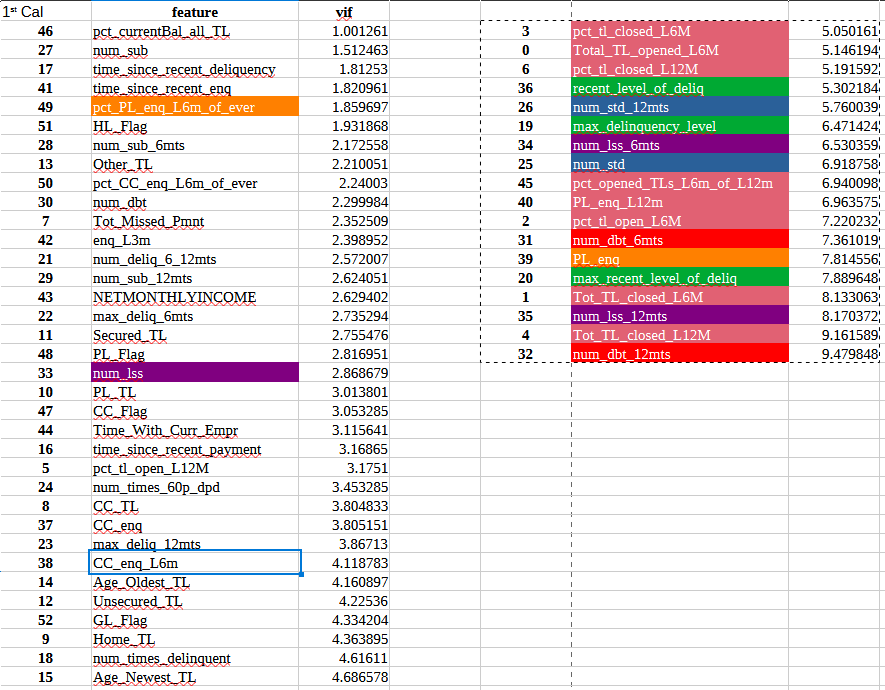

In [32]:
keep_col = keep_col.drop(['PL_enq', 'max_recent_level_of_deliq', 'Tot_TL_closed_L6M', 'num_lss_12mts', 'Tot_TL_closed_L12M', 'num_dbt_12mts'])

array = df[keep_col].values 
vif_values = pd.DataFrame( [(keep_col[i], variance_inflation_factor(array, i)) for i in range(keep_col.size)], 
             columns=['feature', 'vif'] )

print(vif_values[vif_values['vif'] > 5])
# these 4 can be removed

                       feature       vif
1              pct_tl_open_L6M  7.193593
22                     num_std  6.890186
23               num_std_12mts  5.740719
39  pct_opened_TLs_L6m_of_L12m  6.871983


In [33]:
keep_col = keep_col.drop(['num_std_12mts', 'pct_opened_TLs_L6m_of_L12m', 'num_std', 'pct_tl_open_L6M']) # numeric features to keep
cat_col = df.select_dtypes(include='object').columns.drop('Approved_Flag') # categorical columns
all_col = keep_col.to_list() + cat_col.to_list() + ['PROSPECTID', 'Approved_Flag']
df = df[all_col]
print(df.shape)

(42064, 50)


# Treating categorical features for modeling

In [34]:
cat_col = df.select_dtypes(include='object').columns
for col in cat_col:
    print(col, ": ", df[col].unique())

MARITALSTATUS :  ['Married' 'Single']
EDUCATION :  ['12TH' 'GRADUATE' 'SSC' 'POST-GRADUATE' 'UNDER GRADUATE' 'OTHERS'
 'PROFESSIONAL']
GENDER :  ['M' 'F']
last_prod_enq2 :  ['PL' 'ConsumerLoan' 'AL' 'CC' 'others' 'HL']
first_prod_enq2 :  ['PL' 'ConsumerLoan' 'others' 'AL' 'HL' 'CC']
Approved_Flag :  ['P2' 'P1' 'P3' 'P4']


In [35]:
# one-hot encoding
df = pd.get_dummies(df, columns=['MARITALSTATUS', 'GENDER', 'last_prod_enq2', 'first_prod_enq2'])

#label encoding
encode_map = {'SSC':1, 'OTHERS': 1, '12TH': 2, 'GRADUATE': 3, 'UNDER GRADUATE': 3, 'POST-GRADUATE': 4, 'PROFESSIONAL': 4}
df['EDUCATION'] = df['EDUCATION'].map(encode_map)

In [71]:
# saving processed data for modeling
pickle.dump(df, open('../artifacts/processed_data.pkl', 'wb'))

# Basic Modeling 

In [36]:
df['Approved_Flag'].value_counts()

Approved_Flag
P2    25452
P3     6440
P4     5264
P1     4908
Name: count, dtype: int64

Given the moderate imbalance nature of the dataset, the f1-score is used as performance metrics.

In [37]:
X, y = df.drop(['Approved_Flag', 'PROSPECTID'], axis=1), df[['Approved_Flag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

### Base-line Modeling


Trying DCT, SVM, and KNN

In [38]:
def basic_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(model, "accuracy:", accuracy)

    precision, recall, f1score, _ = precision_recall_fscore_support(y_test, y_pred)
    for i, label in enumerate(['p1', 'p2', 'p3', 'p4']):
        print(label, 'class:')
        print('precision:', precision[i])
        print('recall:', recall[i])
        print('f1score:', f1score[i])
    
    return model

In [39]:
dt = DecisionTreeClassifier(random_state=42)
dt = basic_model(dt, X_train, X_test, y_train, y_test)

DecisionTreeClassifier(random_state=42) accuracy: 0.6802567455128967
p1 class:
precision: 0.627254509018036
recall: 0.6173570019723866
f1score: 0.6222664015904572
p2 class:
precision: 0.7909270216962525
recall: 0.7948463825569871
f1score: 0.7928818586258034
p3 class:
precision: 0.3150266971777269
recall: 0.31169811320754715
f1score: 0.3133535660091047
p4 class:
precision: 0.6518375241779497
recall: 0.6550048590864918
f1score: 0.6534173533688803


In [40]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)
svc = basic_model(SVC(random_state=42), X_train_std, X_test_std, y_train, y_test)

SVC(random_state=42) accuracy: 0.7613217639367645
p1 class:
precision: 0.8142681426814268
recall: 0.6528599605522682
f1score: 0.7246852764094143
p2 class:
precision: 0.785513011768606
recall: 0.9393458870168484
f1score: 0.8555695974002528
p3 class:
precision: 0.46016260162601624
recall: 0.21358490566037736
f1score: 0.2917525773195876
p4 class:
precision: 0.7573529411764706
recall: 0.7006802721088435
f1score: 0.7279151943462897


In [41]:
knn = KNeighborsClassifier(n_neighbors=5)
knn = basic_model(knn, X_train_std, X_test_std, y_train, y_test)

KNeighborsClassifier() accuracy: 0.6744324260073695
p1 class:
precision: 0.6400523560209425
recall: 0.4822485207100592
f1score: 0.5500562429696289
p2 class:
precision: 0.7155583837098314
recall: 0.891575817641229
f1score: 0.7939281616803461
p3 class:
precision: 0.34926958831341304
recall: 0.19849056603773585
f1score: 0.2531280076997113
p4 class:
precision: 0.6950819672131148
recall: 0.41205053449951407
f1score: 0.5173886516168396


In [42]:
rf = basic_model(RandomForestClassifier(random_state=42), X_train, X_test, y_train, y_test)

RandomForestClassifier(random_state=42) accuracy: 0.7558540354213716
p1 class:
precision: 0.8197596795727636
recall: 0.6055226824457594
f1score: 0.6965399886557005
p2 class:
precision: 0.7858575727181545
recall: 0.9318136769078296
f1score: 0.8526344427314774
p3 class:
precision: 0.45166402535657685
recall: 0.21509433962264152
f1score: 0.29141104294478526
p4 class:
precision: 0.7221693625118935
recall: 0.7376093294460642
f1score: 0.7298076923076924


SVC perform best out of all, followed by the ensemble technique on DCT i.e., rf., followed by DCT and lastly KNN. However, the time consumed by SVC is around 3 minutes, which restrict parameter tunning (gridsearch).

Note: The p3 class is not getting captured by any of the model.

#### Error analysis for p3 class

In [43]:
# Assign higher weight to P3
test_model = SVC(class_weight={'P3': 5, 'P1': 1, 'P2': 1, 'P4': 1})
test_model = basic_model(test_model, X_train_std, X_test_std, y_train, y_test)

SVC(class_weight={'P1': 1, 'P2': 1, 'P3': 5, 'P4': 1}) accuracy: 0.6966599310590752
p1 class:
precision: 0.811042944785276
recall: 0.6518737672583826
f1score: 0.7227993439037727
p2 class:
precision: 0.8593967517401392
recall: 0.7341922695738354
f1score: 0.7918760021378941
p3 class:
precision: 0.3706243233489715
recall: 0.7750943396226415
f1score: 0.50146484375
p4 class:
precision: 0.90715667311412
recall: 0.4557823129251701
f1score: 0.6067270375161709


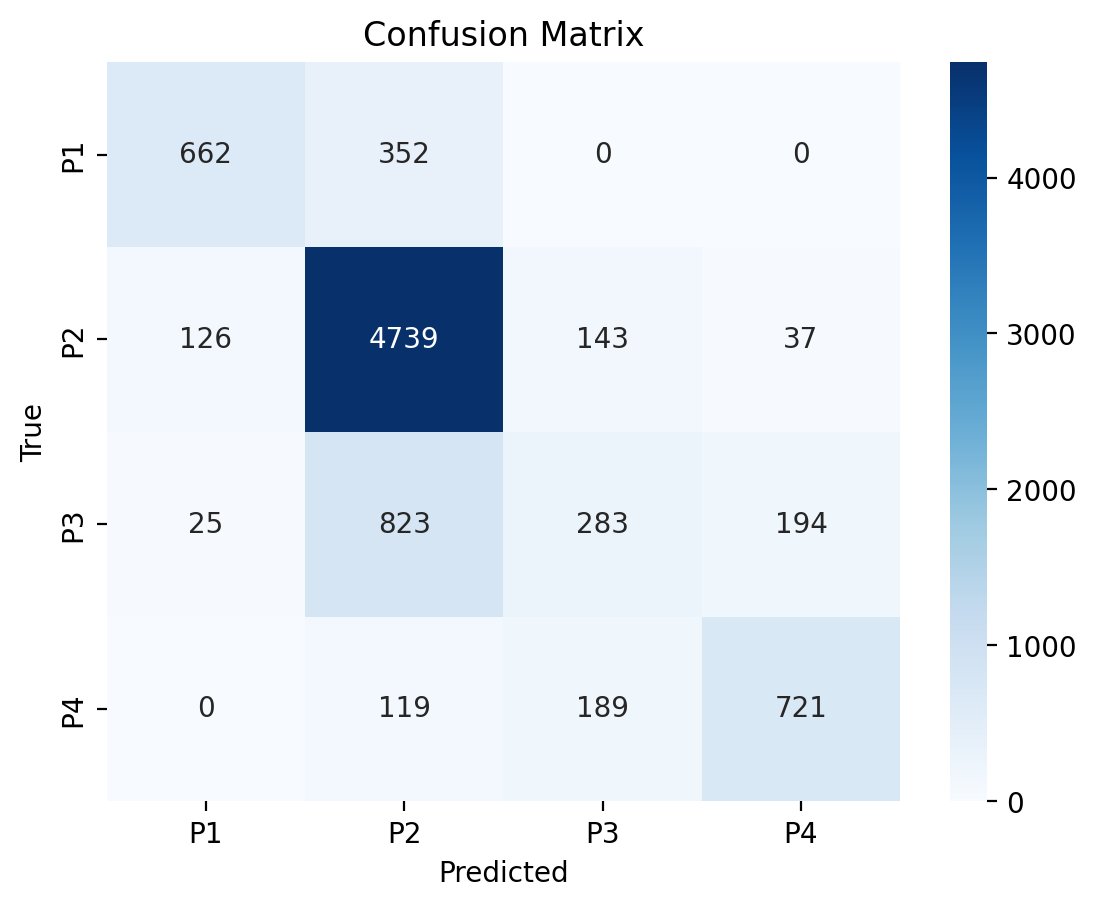

In [44]:
y_pred = svc.predict(X_test_std)  # Predictions of the model
cm = confusion_matrix(y_test, y_pred)  # True labels vs Predicted labels

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['P1', 'P2', 'P3', 'P4'], yticklabels=['P1', 'P2', 'P3', 'P4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

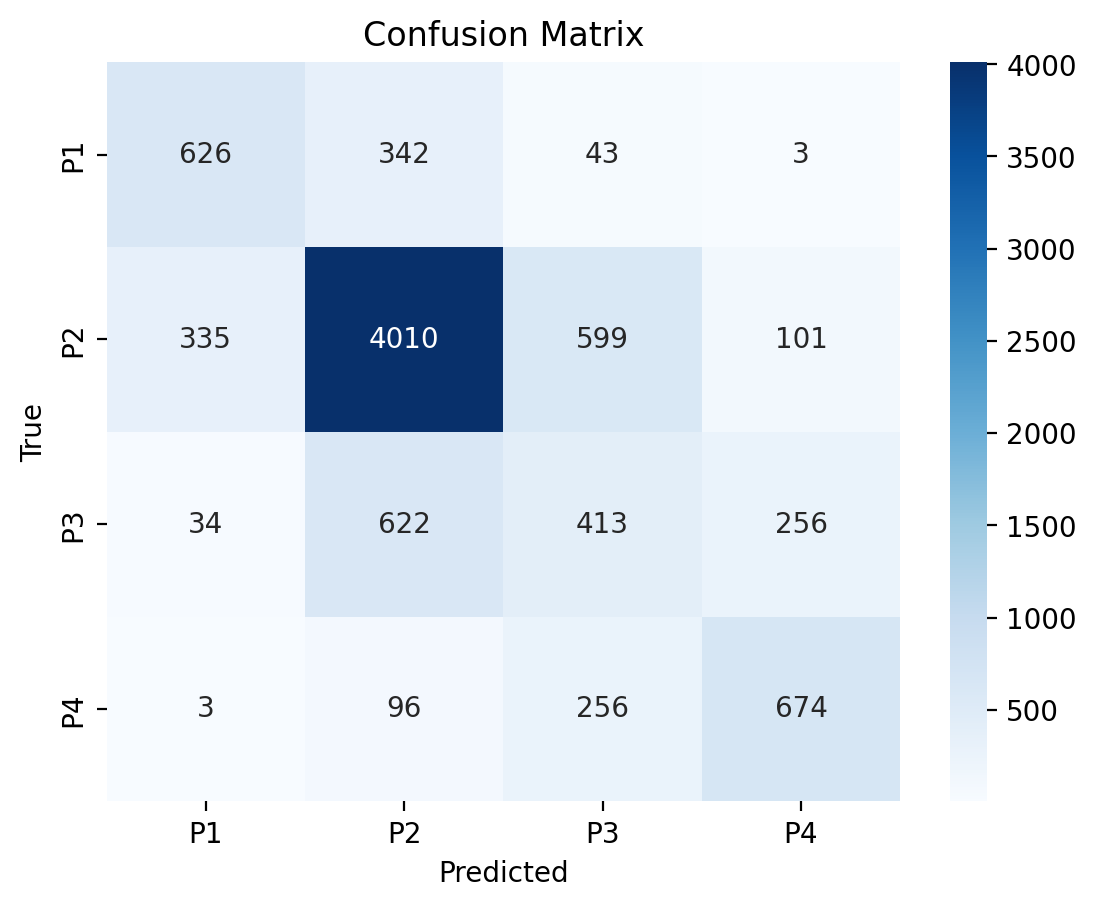

In [45]:
y_pred = dt.predict(X_test)  # Predictions of the model
cm = confusion_matrix(y_test, y_pred)  # True labels vs Predicted labels

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['P1', 'P2', 'P3', 'P4'], yticklabels=['P1', 'P2', 'P3', 'P4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

actual P3 is getting predicted as P2 and P4. Input data corresponding to P3 also doesn't show any pattern or correspondence with false prediction.

In [46]:
X_test[(pd.Series(y_pred) != 'P3') & (y_test['Approved_Flag'] == 'P3')]

,Total_TL_opened_L6M,pct_tl_closed_L6M,pct_tl_open_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,CC_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,Other_TL,Age_Oldest_TL,Age_Newest_TL,time_since_recent_payment,time_since_recent_deliquency,num_times_delinquent,max_delinquency_level,num_deliq_6_12mts,max_deliq_6mts,max_deliq_12mts,num_times_60p_dpd,num_sub,num_sub_6mts,num_sub_12mts,num_dbt,num_dbt_6mts,num_lss,num_lss_6mts,recent_level_of_deliq,CC_enq,CC_enq_L6m,PL_enq_L12m,time_since_recent_enq,enq_L3m,NETMONTHLYINCOME,Time_With_Curr_Empr,pct_currentBal_all_TL,CC_Flag,PL_Flag,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,EDUCATION,MARITALSTATUS_Married,MARITALSTATUS_Single,GENDER_F,GENDER_M,last_prod_enq2_AL,last_prod_enq2_CC,last_prod_enq2_ConsumerLoan,last_prod_enq2_HL,last_prod_enq2_PL,last_prod_enq2_others,first_prod_enq2_AL,first_prod_enq2_CC,first_prod_enq2_ConsumerLoan,first_prod_enq2_HL,first_prod_enq2_PL,first_prod_enq2_others
4227,0,0.0,0.000,0.000,0,0,0,0,1,0,0,50.0,50.0,533.0,0.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1507.0,0.0,18000,65,0.000,0,0,0.0,0.0,0,0,3,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,True
4758,0,0.8,0.400,0.800,0,0,0,0,1,4,0,38.0,8.0,62.0,10.0,4,67.0,2,0.0,8.0,1,0,0,0,0,0,0,0,5,0.0,0.0,0.0,9.0,3.0,30000,66,0.000,0,0,0.0,0.0,0,0,3,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True
1212,0,0.0,0.000,0.000,1,0,0,0,0,4,2,16.0,14.0,91.0,12.0,2,58.0,0,0.0,0.0,0,0,0,0,0,0,0,0,27,0.0,0.0,0.0,88.0,1.0,35000,86,0.010,0,0,0.0,0.0,0,0,2,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True
3648,0,0.0,0.000,0.000,0,1,0,0,0,1,0,24.0,24.0,87.0,0.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,2.0,1.0,0.0,90.0,1.0,25000,80,0.650,1,0,0.0,0.5,0,0,2,True,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False
7092,0,0.0,0.000,0.000,0,0,0,0,1,0,0,24.0,24.0,215.0,0.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,1.0,35000,131,0.000,0,0,0.0,0.0,0,0,3,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7489,0,0.0,0.000,0.500,0,0,0,0,1,1,1,89.0,82.0,343.0,19.0,7,900.0,0,0.0,0.0,6,2,0,0,0,0,0,0,29,0.0,0.0,0.0,14.0,1.0,45000,147,0.000,0,0,0.0,0.0,0,0,1,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,True
5214,1,0.0,0.044,0.000,2,0,0,0,66,2,4,47.0,3.0,92.0,18.0,25,104.0,0,0.0,0.0,7,0,0,0,0,0,0,0,52,0.0,0.0,2.0,55.0,3.0,40000,96,0.388,0,0,1.0,0.0,1,0,3,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,True
8265,0,0.0,0.000,0.333,0,0,0,0,0,3,0,28.0,17.0,330.0,0.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,27.0,2.0,18500,6,0.000,0,0,1.0,0.0,0,0,3,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False
1719,1,0.0,0.250,0.000,1,0,0,0,4,0,0,47.0,4.0,50.0,6.0,8,30.0,6,0.0,30.0,0,0,0,0,0,0,0,0,30,0.0,0.0,0.0,3.0,1.0,50000,122,0.923,0,0,0.0,0.0,1,0,3,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True


In [47]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [101]:
best_rf = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 10, n_estimators= 200)
best_rf = basic_model(best_rf, X_train, X_test, y_train, y_test)

RandomForestClassifier(min_samples_split=10, n_estimators=200) accuracy: 0.7550219897777249
p1 class:
precision: 0.815114709851552
recall: 0.5956607495069034
f1score: 0.6883190883190884
p2 class:
precision: 0.7835994677312043
recall: 0.9337958374628345
f1score: 0.8521298724789725
p3 class:
precision: 0.4446280991735537
recall: 0.2030188679245283
f1score: 0.2787564766839378
p4 class:
precision: 0.7279620853080568
recall: 0.7463556851311953
f1score: 0.7370441458733206


In [49]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb = XGBClassifier()
xgb = basic_model(xgb, X_train, X_test, y_train_encoded, y_test_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...) accuracy: 0.7680969927493165
p1 class:
precision: 0.8036951501154734
recall: 0.6863905325443787
f1score: 0.7404255319148936
p2 class:
precision: 0.8158081705150977
recall: 0.910406342913776
f1score: 0.8605152224824355
p3 class:
preci

XGB is performing better than SVC while being computationally less expensive. fine-tuning XGB.

### fine-tuning

In [68]:
param_grid = {
    'n_estimators': [None, 50, 100, 150, 300],          # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],      # Learning rate
    'max_depth': [3, 5, 7],                 # Maximum tree depth
    'subsample': [0.8, 1.0],                # Subsample ratio of the training data
    'colsample_bytree': [0.8, 1.0],         # Subsample ratio of columns
}

grid_search_xgb = GridSearchCV(estimator=XGBClassifier(random_state=42), 
                               param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_weighted')

grid_search_xgb.fit(X_train, y_train_encoded)

print("Best Parameters:", grid_search_xgb.best_params_)
print("Best Score:", grid_search_xgb.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best Score: 0.7578588138900019


In [70]:
importance = grid_search_xgb.best_estimator_.feature_importances_
features = X_train.columns

features[np.argmax(importance)]

'enq_L3m'

In [61]:
features_with_importance = sorted(
    zip(features, importance),
    key=lambda x: x[1],
    reverse=True
)

features_with_importance

[('enq_L3m', 0.20030604),
 ('Age_Oldest_TL', 0.08955781),
 ('time_since_recent_deliquency', 0.07213204),
 ('pct_PL_enq_L6m_of_ever', 0.06308141),
 ('time_since_recent_enq', 0.032297265),
 ('max_deliq_12mts', 0.027259974),
 ('Secured_TL', 0.020953357),
 ('Age_Newest_TL', 0.01967959),
 ('max_delinquency_level', 0.01805858),
 ('pct_currentBal_all_TL', 0.01703543),
 ('HL_Flag', 0.016653322),
 ('Other_TL', 0.01605532),
 ('recent_level_of_deliq', 0.014783797),
 ('first_prod_enq2_PL', 0.014379232),
 ('Home_TL', 0.014359768),
 ('Tot_Missed_Pmnt', 0.014257642),
 ('pct_tl_open_L12M', 0.012395156),
 ('PL_TL', 0.012289203),
 ('time_since_recent_payment', 0.011188581),
 ('num_times_delinquent', 0.011145572),
 ('pct_tl_closed_L12M', 0.0111354785),
 ('first_prod_enq2_ConsumerLoan', 0.010958741),
 ('last_prod_enq2_others', 0.010774135),
 ('last_prod_enq2_CC', 0.01070203),
 ('num_times_60p_dpd', 0.0106605105),
 ('first_prod_enq2_CC', 0.010632253),
 ('CC_TL', 0.010495204),
 ('Total_TL_opened_L6M', 0.010

In [ ]:
# saving the best model
pickle.dump(grid_search_xgb.best_estimator_, open('../artifacts/xgb_best_v1.pkl', 'wb'))

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

print("Best Parameters:", grid_search_rf.best_params_)
print("Best Score:", grid_search_rf.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [97]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [98]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [10, 1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svc = SVC(random_state=42)
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_std, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
xgb_classifier = XGBClassifier(objective='multi:softmax',  num_class=15)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('rf accuracy', accuracy)

imp_xgb1 = pd.DataFrame()
imp_xgb1['feature'] = xgb_classifier.feature_names_in_
imp_xgb1['importance'] = xgb_classifier.feature_importances_
imp_xgb1.sort_values('importance', ascending=False, inplace=True)
imp_xgb1[imp_xgb1['importance'] > 0].iloc[0:25]

#### dataset: full data - no null - no infite vif feature 

In [ ]:
no_null_a2 = no_null_a1[vif_values['feature'].values]
no_null_a2 = pd.concat( (no_null_a1.select_dtypes(include=object), no_null_a2) )
enc_no_null_a2 = cat_encoding(no_null_a1)

X, y = enc_no_null_a2.drop(['Approved_Flag'], axis=1), enc_no_null_a2[['Approved_Flag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("dt accuracy:", accuracy)

imp_dt2 = pd.DataFrame()
imp_dt2['feature'] = dt.feature_names_in_
imp_dt2['importance'] = dt.feature_importances_
imp_dt2.sort_values('importance', ascending=False, inplace=True)
imp_dt2[imp_dt2['importance'] > 0].iloc[0:25]

In [ ]:
xgb_classifier = XGBClassifier(objective='multi:softmax',  num_class=15)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('rf accuracy', accuracy)

imp_xgb2 = pd.DataFrame()
imp_xgb2['feature'] = xgb_classifier.feature_names_in_
imp_xgb2['importance'] = xgb_classifier.feature_importances_
imp_xgb2.sort_values('importance', ascending=False, inplace=True)
imp_xgb2[imp_xgb2['importance'] > 0].iloc[0:25]

#### dataset: full data - no null - low vif

In [ ]:
numeric_col = vif_values[vif_values['vif'] > 5]['feature'].values
categoric_col = no_null_a1.select_dtypes(include=object).columns
keep_col = np.concatenate( (numeric_col , categoric_col) )
enc_no_null_a3 = cat_encoding(no_null_a1[keep_col])
print(enc_no_null_a3.shape)

X, y = enc_no_null_a3.drop(['Approved_Flag'], axis=1), enc_no_null_a3[['Approved_Flag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("dt [low vif] accuracy:", accuracy)

imp_dt3 = pd.DataFrame()
imp_dt3['feature'] = dt.feature_names_in_
imp_dt3['importance'] = dt.feature_importances_
imp_dt3.sort_values('importance', ascending=False, inplace=True)
imp_dt3[imp_dt3['importance'] > 0].iloc[0:25]

In [ ]:
xgb_classifier = XGBClassifier(objective='multi:softmax',  num_class=15)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('rf accuracy', accuracy)

imp_xgb3 = pd.DataFrame()
imp_xgb3['feature'] = xgb_classifier.feature_names_in_
imp_xgb3['importance'] = xgb_classifier.feature_importances_
imp_xgb3.sort_values('importance', ascending=False, inplace=True)
imp_xgb3[imp_xgb3['importance'] > 0].iloc[0:25]

Choosing only low vif feature didn't improved the accuracy much.

In [ ]:
# merging importance with vif values
vif_imp = pd.merge(vif_values, imp_xgb2, on='feature', how='left').sort_values(['importance', 'vif'], ascending=False)
vif_imp.shape

In [ ]:
vif_imp

In [ ]:
# feature selected for further modeling basis vif and importance score along with the limited banking knowledge
numeric_col = [ 'Age_Oldest_TL', 'enq_L3m', 'time_since_recent_enq', 'time_since_recent_deliquency', 
'num_std', 'Time_With_Curr_Empr', 'time_since_recent_payment', 'Age_Newest_TL', 
'NETMONTHLYINCOME', 'AGE', 'max_deliq_12mts', 'max_delinquency_level', 'recent_level_of_deliq', 
'pct_PL_enq_L6m_of_L12m', 'enq_L12m', 'pct_tl_open_L12M', 'num_std_6mts', 'pct_tl_closed_L12M', 
'pct_tl_open_L6M', 'max_deliq_6mts', 'num_times_30p_dpd', 'num_times_60p_dpd' ]

categoric_col = no_null_a1.select_dtypes(include=object).columns
keep_col = np.concatenate( (numeric_col , categoric_col) )
no_null_a3 = no_null_a1[keep_col]
enc_no_null_a3 = cat_encoding(no_null_a3)
print(enc_no_null_a3.shape)

X, y = enc_no_null_a3.drop(['Approved_Flag'], axis=1), enc_no_null_a3[['Approved_Flag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

xgb_classifier = XGBClassifier(objective='multi:softmax',  num_class=15)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('rf accuracy', accuracy)

imp_xgb4 = pd.DataFrame()
imp_xgb4['feature'] = xgb_classifier.feature_names_in_
imp_xgb4['importance'] = xgb_classifier.feature_importances_
imp_xgb4.sort_values('importance', ascending=False, inplace=True)
imp_xgb4

In [ ]:
# feature selected for further modeling basis vif and importance score along with the limited banking knowledge
numeric_col = [ 'enq_L3m', 'Age_Oldest_TL', 'time_since_recent_deliquency', 'time_since_recent_enq', 'num_std', 'time_since_first_deliquency', 'max_deliq_12mts', 'max_delinquency_level', 'Age_Newest_TL', 'max_recent_level_of_deliq', 'recent_level_of_deliq', 'max_deliq_6mts', 'pct_tl_open_L12M', 'pct_CC_enq_L6m_of_L12m', 'enq_L12m', 'pct_tl_open_L6M', 'enq_L6m', 'pct_tl_closed_L12M', 'PL_enq_L6m', 'num_times_30p_dpd', 'time_since_recent_payment', 'Total_TL_opened_L12M', 'CC_enq_L6m', 'Time_With_Curr_Empr', 'NETMONTHLYINCOME', 'pct_tl_closed_L6M', 'tot_enq', 'Tot_Missed_Pmnt', 'PL_enq', 'PL_enq_L12m', 'Tot_TL_closed_L6M', 'AGE', 'CC_enq_L12m', 'Total_TL_opened_L6M', 'pct_CC_enq_L6m_of_ever', 'pct_opened_TLs_L6m_of_L12m', 'pct_closed_tl', 'Tot_TL_closed_L12M', 'CC_enq', 'num_times_60p_dpd', 'num_lss', 'num_times_delinquent', 'num_sub', 'num_sub_12mts', 'num_dbt' ]

categoric_col = no_null_a1.select_dtypes(include=object).columns
keep_col = np.concatenate( (numeric_col , categoric_col) )
enc_no_null_a3 = cat_encoding(no_null_a1[keep_col])
print(enc_no_null_a3.shape)

X, y = enc_no_null_a3.drop(['Approved_Flag'], axis=1), enc_no_null_a3[['Approved_Flag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

xgb_classifier = XGBClassifier(objective='multi:softmax',  num_class=15)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('rf accuracy', accuracy)


### Different Apporach

In [145]:
# max deliqneunt level last 12 months have higher importance than other 2 features, per vif_imp.
no_null_a4 = df.dropna(subset=['time_since_recent_payment']).drop([['max_deliq_6mts', 'max_deliq_12mts']], axis=1)
no_null_a4.drop(['PROSPECTID', 'Credit_Score'], axis=1, inplace=True)

numeric_col = no_null_a4.select_dtypes(exclude=object).columns

# Calculate VIF for each numeric feature
vif_values_new = pd.DataFrame()
vif_values_new['feature'] = numeric_col

vif_values_new['vif'] = [variance_inflation_factor(no_null_a4[numeric_col], i) for i in range(numeric_col.shape[0])]
vif_values_new = vif_values_new[vif_values_new['vif'] < np.inf]
vif_values_new.sort_values('vif', inplace=True)

In [ ]:
no_null_a4 = pd.concat( (no_null_a4[vif_values_new['feature'].values], no_null_a4.select_dtypes(include=object)) )
enc_no_null_a4 = cat_encoding(no_null_a4)

X, y = enc_no_null_a4.drop(['Approved_Flag'], axis=1), enc_no_null_a4[['Approved_Flag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
xgb_classifier = XGBClassifier(objective='multi:softmax',  num_class=5)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('rf accuracy', accuracy)

In [ ]:
imp_xgb5 = pd.DataFrame()
imp_xgb5['feature'] = xgb_classifier.feature_names_in_
imp_xgb5['importance'] = xgb_classifier.feature_importances_
imp_xgb5.sort_values('importance', ascending=False, inplace=True)
imp_xgb5[imp_xgb5['importance'] > 0]

In [ ]:
vif_imp_new = pd.merge(vif_values, imp_xgb5[imp_xgb5['importance'] > 0], on='feature', how='left').sort_values(['importance', 'vif'], ascending=False)
vif_imp_new

In [ ]:
no_null_a5 = pd.concat( (no_null_a4[vif_imp_new['feature'].values], no_null_a4.select_dtypes(include=object)) )
enc_no_null_a5 = cat_encoding(no_null_a5)

X, y = enc_no_null_a5.drop(['Approved_Flag'], axis=1), enc_no_null_a5[['Approved_Flag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
xgb_classifier = XGBClassifier(objective='multi:softmax',  num_class=15)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('rf accuracy', accuracy)

In [ ]:
imp_xgb5 = pd.DataFrame()
imp_xgb5['feature'] = xgb_classifier.feature_names_in_
imp_xgb5['importance'] = xgb_classifier.feature_importances_
imp_xgb5.sort_values('importance', ascending=False, inplace=True)
imp_xgb5[imp_xgb5['importance'] > 0]

In [ ]:
vif_imp_new = pd.merge(vif_values, imp_xgb5[imp_xgb5['importance'] > 0], on='feature', how='left').sort_values(['importance', 'vif'], ascending=False)
